In [0]:
from __future__ import print_function, division
import os
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io
from skimage.transform import resize, rescale, rotate, setup, warp
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.patches as patches

from skimage.color import rgb2gray

import PIL
from PIL import Image

from google.colab import output

from sklearn.linear_model import LinearRegression

In [2]:
%cd /content/
if(os.path.isdir('/content/Lithuanian_OCR') == False):
  !git clone https://github.com/PauliusMilmantas/Lithuanian_OCR

/content
Cloning into 'Lithuanian_OCR'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 3968 (delta 7), reused 33 (delta 5), pack-reused 3933
Receiving objects: 100% (3968/3968), 234.15 MiB | 38.42 MiB/s, done.
Resolving deltas: 100% (614/614), done.


In [0]:
class Net(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)        
        out = self.relu2(out)     
        out = self.fc3(out)
        return out

In [11]:
networks = []
batches = os.listdir('/content/Lithuanian_OCR/Trained_model')

for batch in batches:
  if(batch != 'treshold.txt'):
    nt = Net(4096, 1500, 300, 3)

    nt.load_state_dict(torch.load('/content/Lithuanian_OCR/Trained_model/' + batch + '/model.pth'))
    nt.eval()

    networks.append(nt)

print("Loaded {} networks".format(len(networks)))

treshold = []

with open('/content/Lithuanian_OCR/Trained_model/treshold.txt') as fp:
   line = fp.readline()
   cnt = 0
   while line:
       treshold.append(line.strip().split(' ')[1])
       line = fp.readline()
       cnt += 1

if(len(treshold) != len(networks)):
  print('ERROR LOADING TRESHOLDS!')

Loaded 2 networks


In [0]:
def proccess_image(path):
  image = io.imread(path)
  image = rgb2gray(image)
  image = resize(image, (64, 64))
  
  return torch.tensor(image)

def get_max_from_tensor(data):
  maxVal = data[0]
  maxId = 0
  for i in range(len(data)):
    if(data[i] > maxVal):
      maxVal = data[i]
      maxId = i

  return maxId + 1

def get_result(data):
  idx = get_max_from_tensor(data) - 1

  if(data[idx] > 6):
    return idx + 1
  # No object found
  elif(data[idx] <= 6):
    return 0
  # Best guess is that there is no object
  else:
    return 0

def find_in_array(arr, element):
  idx = 0
  found = []

  for el in arr:
    if(el == element):
      found.append(idx)
    idx += 1

  return found

def prepare_image_for_network(image):
  image = resize(image, (64, 64))

  return image

def parse_letters(letter_idx, network_idx):
  if(network_idx == 0):
    switcher = {
        1: 'A',
        2: 'B',
        3: 'C'
    }
  elif(network_idx == 1):
        switcher = {
        1: 'a',
        2: 'P',
        3: 'u'
    }

  return switcher.get(letter_idx)

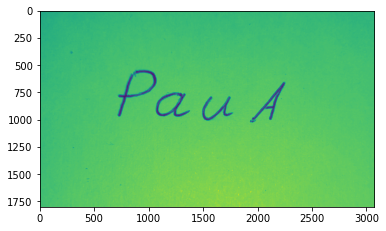

In [34]:
image = io.imread('/content/Lithuanian_OCR/Examples/example3.jpg')

# image = rotate(image, 90)
image = rgb2gray(image)
plt.imshow(image)

Searching color distances...
Sorting by y...
Removing far point by x axis
Sorting by x...
Removing far point by x axis


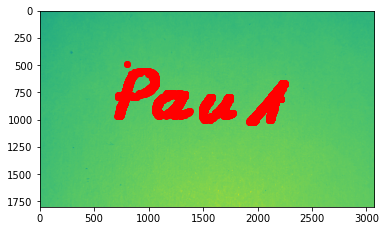

6453


In [35]:
registered_x = []
registered_y = []

print("Searching color distances...")
for y in range(image.shape[0]):
  last_val = image[y][0]
  for x in range(image.shape[1]):
    if(abs(last_val - image[y][x]) >= 0.1):
      registered_x.append(x)
      registered_y.append(y)
    last_val = image[y][x]

# Sorting points by y
print("Sorting by y...")
sorted = False
while(sorted == False):
  sorted = True
  for i in range(len(registered_y)-1):
    if(registered_y[i] > registered_y[i+1]):
      sorted = False
      buffX = registered_x[i]
      buffY = registered_y[i]

      registered_x[i] = registered_x[i+1]
      registered_y[i] = registered_y[i+1]

      registered_x[i+1] = buffX
      registered_y[i+1] = buffY

# Filter points that are far away from each other
print("Removing far point by x axis")
removed = True
while(removed == True):
  removed = False
  buffer_x = []
  buffer_y = []
  distance_treshold = 200
  for i in range(len(registered_y)-1):
    if(i != len(registered_y)-1):
      if(abs(registered_y[i+1] - registered_y[i]) < distance_treshold):
        buffer_x.append(registered_x[i])
        buffer_y.append(registered_y[i])
      else:
        removed = True
    else:
      if(abs(registered_y[i] - registered_y[i-1]) < distance_treshold):
        buffer_x.append(registered_x[i])
        buffer_y.append(registered_y[i])
      else:
        removed = True

  registered_x = buffer_x
  registered_y = buffer_y
  
# Sorting points by x
print("Sorting by x...")
sorted = False
while(sorted == False):
  sorted = True
  for i in range(len(registered_x)-1):
    if(registered_x[i] > registered_x[i+1]):
      sorted = False
      buffX = registered_x[i]
      buffY = registered_y[i]

      registered_x[i] = registered_x[i+1]
      registered_y[i] = registered_y[i+1]

      registered_x[i+1] = buffX
      registered_y[i+1] = buffY

# Filter points that are far away from each other
print("Removing far point by x axis")
removed = True
while(removed == True):
  removed = False
  buffer_x = []
  buffer_y = []
  distance_treshold = 200
  for i in range(len(registered_x)-1):
    if(i != len(registered_x)-1):
      if(abs(registered_x[i+1] - registered_x[i]) < distance_treshold):
        buffer_x.append(registered_x[i])
        buffer_y.append(registered_y[i])
      else:
        removed = True
    else:
      if(abs(registered_x[i] - registered_x[i-1]) < distance_treshold):
        buffer_x.append(registered_x[i])
        buffer_y.append(registered_y[i])
      else:
        removed = True

  registered_x = buffer_x
  registered_y = buffer_y

implot = plt.imshow(image)
plt.scatter(registered_x, registered_y, c='r')
plt.show()

print(len(registered_x))

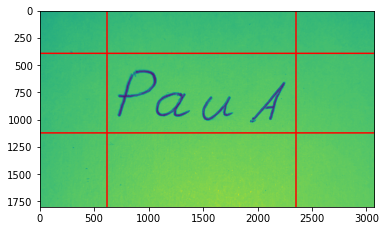

In [36]:
margins = 100

# Finding lowest y point
lowest_y = registered_y[0]
lowest_x = registered_x[0]

highest_y = registered_y[0]
highest_x = registered_x[0]

for i in range(len(registered_x)):
  if(registered_y[i] > highest_y):
    highest_x = registered_x[i]
    highest_y = registered_y[i]

  if(registered_y[i] < lowest_y):
    lowest_x = registered_x[i]
    lowest_y = registered_y[i]

# Finding smallest x point
smallest_x = registered_x[0]
smallest_y = registered_y[0]

biggest_x = registered_x[0]
biggest_y = registered_y[0]

for i in range(len(registered_x)):
  if(registered_x[i] > biggest_x):
    biggest_x = registered_x[i]
    biggest_y = registered_y[i]

  if(registered_x[i] < smallest_x):
    smallest_x = registered_x[i]
    smallest_y = registered_y[i]

implot = plt.imshow(image)
plt.plot(np.arange(0, image.shape[1], 1), np.repeat(highest_y+margins, image.shape[1]), c='r')
plt.plot(np.arange(0, image.shape[1], 1), np.repeat(lowest_y-margins, image.shape[1]), c='r')
plt.axvline(smallest_x-margins, c='r')
plt.axvline(biggest_x+margins, c='r')
plt.show()

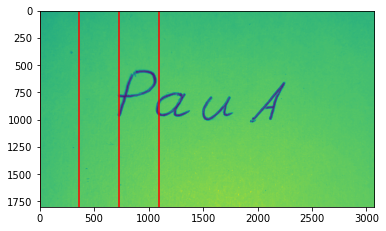

In [43]:
use_y_restriction = False
height = highest_y - lowest_y + margins * 2

# Starting points for reading image
implot = plt.imshow(image)
for i in range(int(image.shape[0]/(height/2))):
  plt.axvline(i*(height/2), c='r')
plt.show()

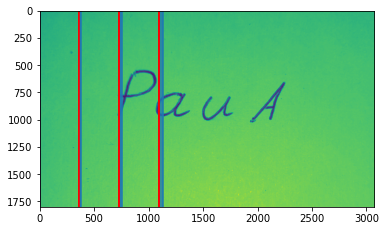

16


In [44]:
# Checking image coverage
stepSize = 5

counter = 0
implot = plt.imshow(image)

for i in range(int(image.shape[0]/(height/2))):
  for m in range(int(image.shape[0]/(height/2))):
    if(i * (height/2) + m * i * int(image.shape[0]/(height/2)) <= image.shape[0]):
      plt.axvline(i*(height/2), c='r')
      plt.axvline(i * (height/2) + m * i * int(image.shape[0]/(height/2)))
      counter += 1
plt.show()
print(counter)

In [48]:
letters = []
scanned_images = 0

for i in range(int(image.shape[0]/(height/2))):
  maxProb = 0
  gotRes = 0
  network_idx = 0

  for m in range(int((height/2)/stepSize)):
    img = image[int(i*(height/2)):int((i+1)*(height/2) + m * (height/2)/stepSize), lowest_y-margins:highest_y+margins]

    for t in range(len(networks)):
      output = networks[t](torch.Tensor(prepare_image_for_network(img).flatten()).float())
      scanned_images += 1
      res = get_result(output)

      prob = output[res - 1]
      if(prob > float(treshold[t])):
        if(prob > maxProb):
          maxProb = prob
          gotRes = res
          network_idx = t

  if(maxProb != 0 and maxProb > 6):
    print("Found: {} Network_idx: {} Prob: {}".format(gotRes, network_idx, maxProb))
    i += 1
    letters.append(parse_letters(gotRes, network_idx))

print("Scanned areas: {}".format(scanned_images))

Found: 1 Network_idx: 0 Prob: 7.772366046905518
Found: 1 Network_idx: 0 Prob: 9.379857063293457
Found: 2 Network_idx: 1 Prob: 8.661419868469238
Scanned areas: 584


In [50]:
# Removing duplicates from array
answer = []
last_letter = ""
for x in letters:
  if last_letter == "":
    last_letter = x
    answer.append(x)
  else:
    if(x != last_letter):
      last_letter = x
      answer.append(x)

print(answer)

['A', 'P']
